In [1]:
suppressPackageStartupMessages({
    library(ComplexHeatmap)
    library(scran)
    library(escape)
    library(scater)
    library(tidyverse)
})

In [29]:
sce <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_epithelial.rds")

In [31]:
sce <- sce[, grepl("^HCC", sce$leiden_anno)]

In [32]:
sce

class: SingleCellExperiment 
dim: 60682 670 
metadata(4): pca neighbors umap leiden
assays(2): logcounts counts
rownames(60682): DDX11L1 WASH7P_ENSG00000227232 ... HPV-mRTRX7 HPV-mSD2
rowData names(10): Geneid Chr ... highly_variable varm
colnames(670): TP5-100-0322 TP5-108-0322 ... TP5-9-20180110
  TP5-95-20180110
colData names(31): cell.id cell.type ... leiden_sub leiden_anno
reducedDimNames(4): PCA UMAP X_pca X_umap
mainExpName: NULL
altExpNames(0):

# NMF program

In [33]:
# Calculate CPM
cpm(sce) <- calculateCPM(sce)

In [5]:
# Function
suppressPackageStartupMessages(library(NMF))
nmf_programs <- function(cpm, is.log=F, rank, method="snmf/r", seed=1) {
  if(is.log==F) CP100K_log <- log2((cpm/10) + 1) else CP100K_log <- cpm
  CP100K_log <- CP100K_log[apply(CP100K_log, 1, function(x) length(which(x > 3.5)) > ncol(CP100K_log)*0.02),]
  CP100K_log <- CP100K_log - rowMeans(CP100K_log)
  CP100K_log[CP100K_log < 0] <- 0
  nmf_programs <- nmf(CP100K_log, rank=rank, method=method, seed=seed)
  nmf_programs_scores <- list(w_basis=basis(nmf_programs), h_coef=t(coef(nmf_programs)))                                 
  return(nmf_programs_scores)
}

In [6]:
donor <- c("D20170322", "D20170327", "D20171220", "D20180110")

## Perform NMF with ranks ranging from 3 to 9       

In [7]:
w_basis_tumor <- list() # nmf gene scores
h_coef_tumor <- list() # nmf cell scores

In [26]:
for(i in donor) {
    #log_info("NMF for {i}")
    w <- NULL
    h <- NULL
    mt_for_nmf <- as.matrix(cpm(sce[keep, sce$donor == i]))
   
    for (j in 3:9) {
        #log_info("Rank {j}")
        n <- nmf_programs(mt_for_nmf, rank=j)
        colnames(n$w_basis) <- paste0(i, "_", j, ".", 1:j)
        colnames(n$h_coef) <- paste0(i, "_", j, ".", 1:j)
        w <- cbind(w, n$w_basis)
        h <- cbind(h, n$h_coef)
    }
    
    w_basis_tumor[[i]] <- w
    h_coef_tumor[[i]] <- h
}

## Writing out

In [28]:
getwd()

[1] "/raid1/heyao/project/scHCC-tumor/analyses/07_Tumor_programs"

In [29]:
saveRDS(w_basis_tumor, file = "./output/NMF/w_basis_tumor.rds")
saveRDS(h_coef_tumor, file = "./output/NMF/h_coef_tumor.rds")

# Identify Recurrent Program

In [34]:
w_basis_tumor <- readRDS("./output/NMF/w_basis_tumor.rds")
h_coef_tumor <- readRDS("./output/NMF/h_coef_tumor.rds")

In [35]:
# - nmf_programs = a list; each element contains a matrix with NMF programs (top 50 genes) generated for a specific cell line using different NMF factorization ranks. 
# - intra_min = minimum overlap with a program from the same cell line (for selecting robust programs)
# - intra_max = maximum overlap with a program from the same cell line (for removing redundant programs)
# - inter_filter = logical; indicates whether programs should be filtered based on their similarity to programs of other cell lines
# - inter_min = minimum overlap with a program from another cell line 

# Returns a character vector with the NMF programs selected

robust_nmf_programs <- function(nmf_programs, intra_min = 35, intra_max = 10, inter_filter=T, inter_min = 10) {
    
    # Select NMF programs based on the minimum overlap with other NMF programs from the same cell line
    intra_intersect <- lapply(nmf_programs, function(z) apply(z, 2, function(x) apply(z, 2, function(y) length(intersect(x,y))))) 
    intra_intersect_max <- lapply(intra_intersect, function(x) apply(x, 2, function(y) sort(y, decreasing = T)[2]))             
    nmf_sel <- lapply(names(nmf_programs), function(x) nmf_programs[[x]][,intra_intersect_max[[x]]>=intra_min]) 
    names(nmf_sel) <- names(nmf_programs)
                            
    # Select NMF programs based on i) the maximum overlap with other NMF programs from the same cell line and
    # ii) the minimum overlap with programs from another cell line
    nmf_sel_unlist <- do.call(cbind, nmf_sel)
    inter_intersect <- apply(nmf_sel_unlist , 2, function(x) apply(nmf_sel_unlist , 2, function(y) length(intersect(x,y)))) ## calculating intersection between all programs
                                                                   
    final_filter <- NULL 
    for(i in names(nmf_sel)) {
        a <- inter_intersect[grep(i, colnames(inter_intersect), invert = T),grep(i, colnames(inter_intersect))]
        b <- sort(apply(a, 2, max), decreasing = T) # for each cell line, ranks programs based on their maximum overlap with programs of other cell lines
        if(inter_filter==T) b <- b[b>=inter_min] # selects programs with a maximum intersection of at least 10
        if(length(b) > 1) {
            c <- names(b[1]) 
            for(y in 2:length(b)) {
                if(max(inter_intersect[c,names(b[y])]) <= intra_max) c <- c(c,names(b[y])) # selects programs iteratively from top-down. Only selects programs that have a intersection smaller than 10 with a previously selected programs
                }
            final_filter <- c(final_filter, c)
        } else {
            final_filter <- c(final_filter, names(b))
        }
    }
    return(final_filter)                                                      
}
    

In [36]:
nmf_programs_genes_tumor <- w_basis_tumor
nmf_programs_sig_tumor <- lapply(nmf_programs_genes_tumor, function(x) apply(x, 2, function(y) names(sort(y, decreasing = T))[1:50]))

for each cell line, select robust NMF programs (i.e. obseved using different ranks in the same cell line), remove redundancy due to multiple ranks, and apply a filter based on the similarity to programs from other cell lines. 

In [37]:
nmf_filter_tumor <- robust_nmf_programs(nmf_programs_sig_tumor, intra_min = 35, intra_max = 10, inter_filter=T, inter_min = 10)
nmf_programs_sig_tumor <- lapply(nmf_programs_sig_tumor, function(x) x[, is.element(colnames(x), nmf_filter_tumor),drop=F])
nmf_programs_sig_tumor <- do.call(cbind, nmf_programs_sig_tumor)

## Calculate similarity between programs


In [38]:
nmf_intersect_tumor <- apply(nmf_programs_sig_tumor , 2, function(x) apply(nmf_programs_sig_tumor , 2, function(y) length(intersect(x,y)))) 

## Hierarchical clustering of the similarity matrix 


In [39]:
nmf_intersect_hc_tumor <- hclust(as.dist(50-nmf_intersect_tumor), method="ward.D2") 
nmf_intersect_hc_tumor <- reorder(as.dendrogram(nmf_intersect_hc_tumor), colMeans(nmf_intersect_tumor))
nmf_intersect_tumor <- nmf_intersect_tumor[order.dendrogram(nmf_intersect_hc_tumor), order.dendrogram(nmf_intersect_hc_tumor)]

## Plot similarity matrix heatmap     


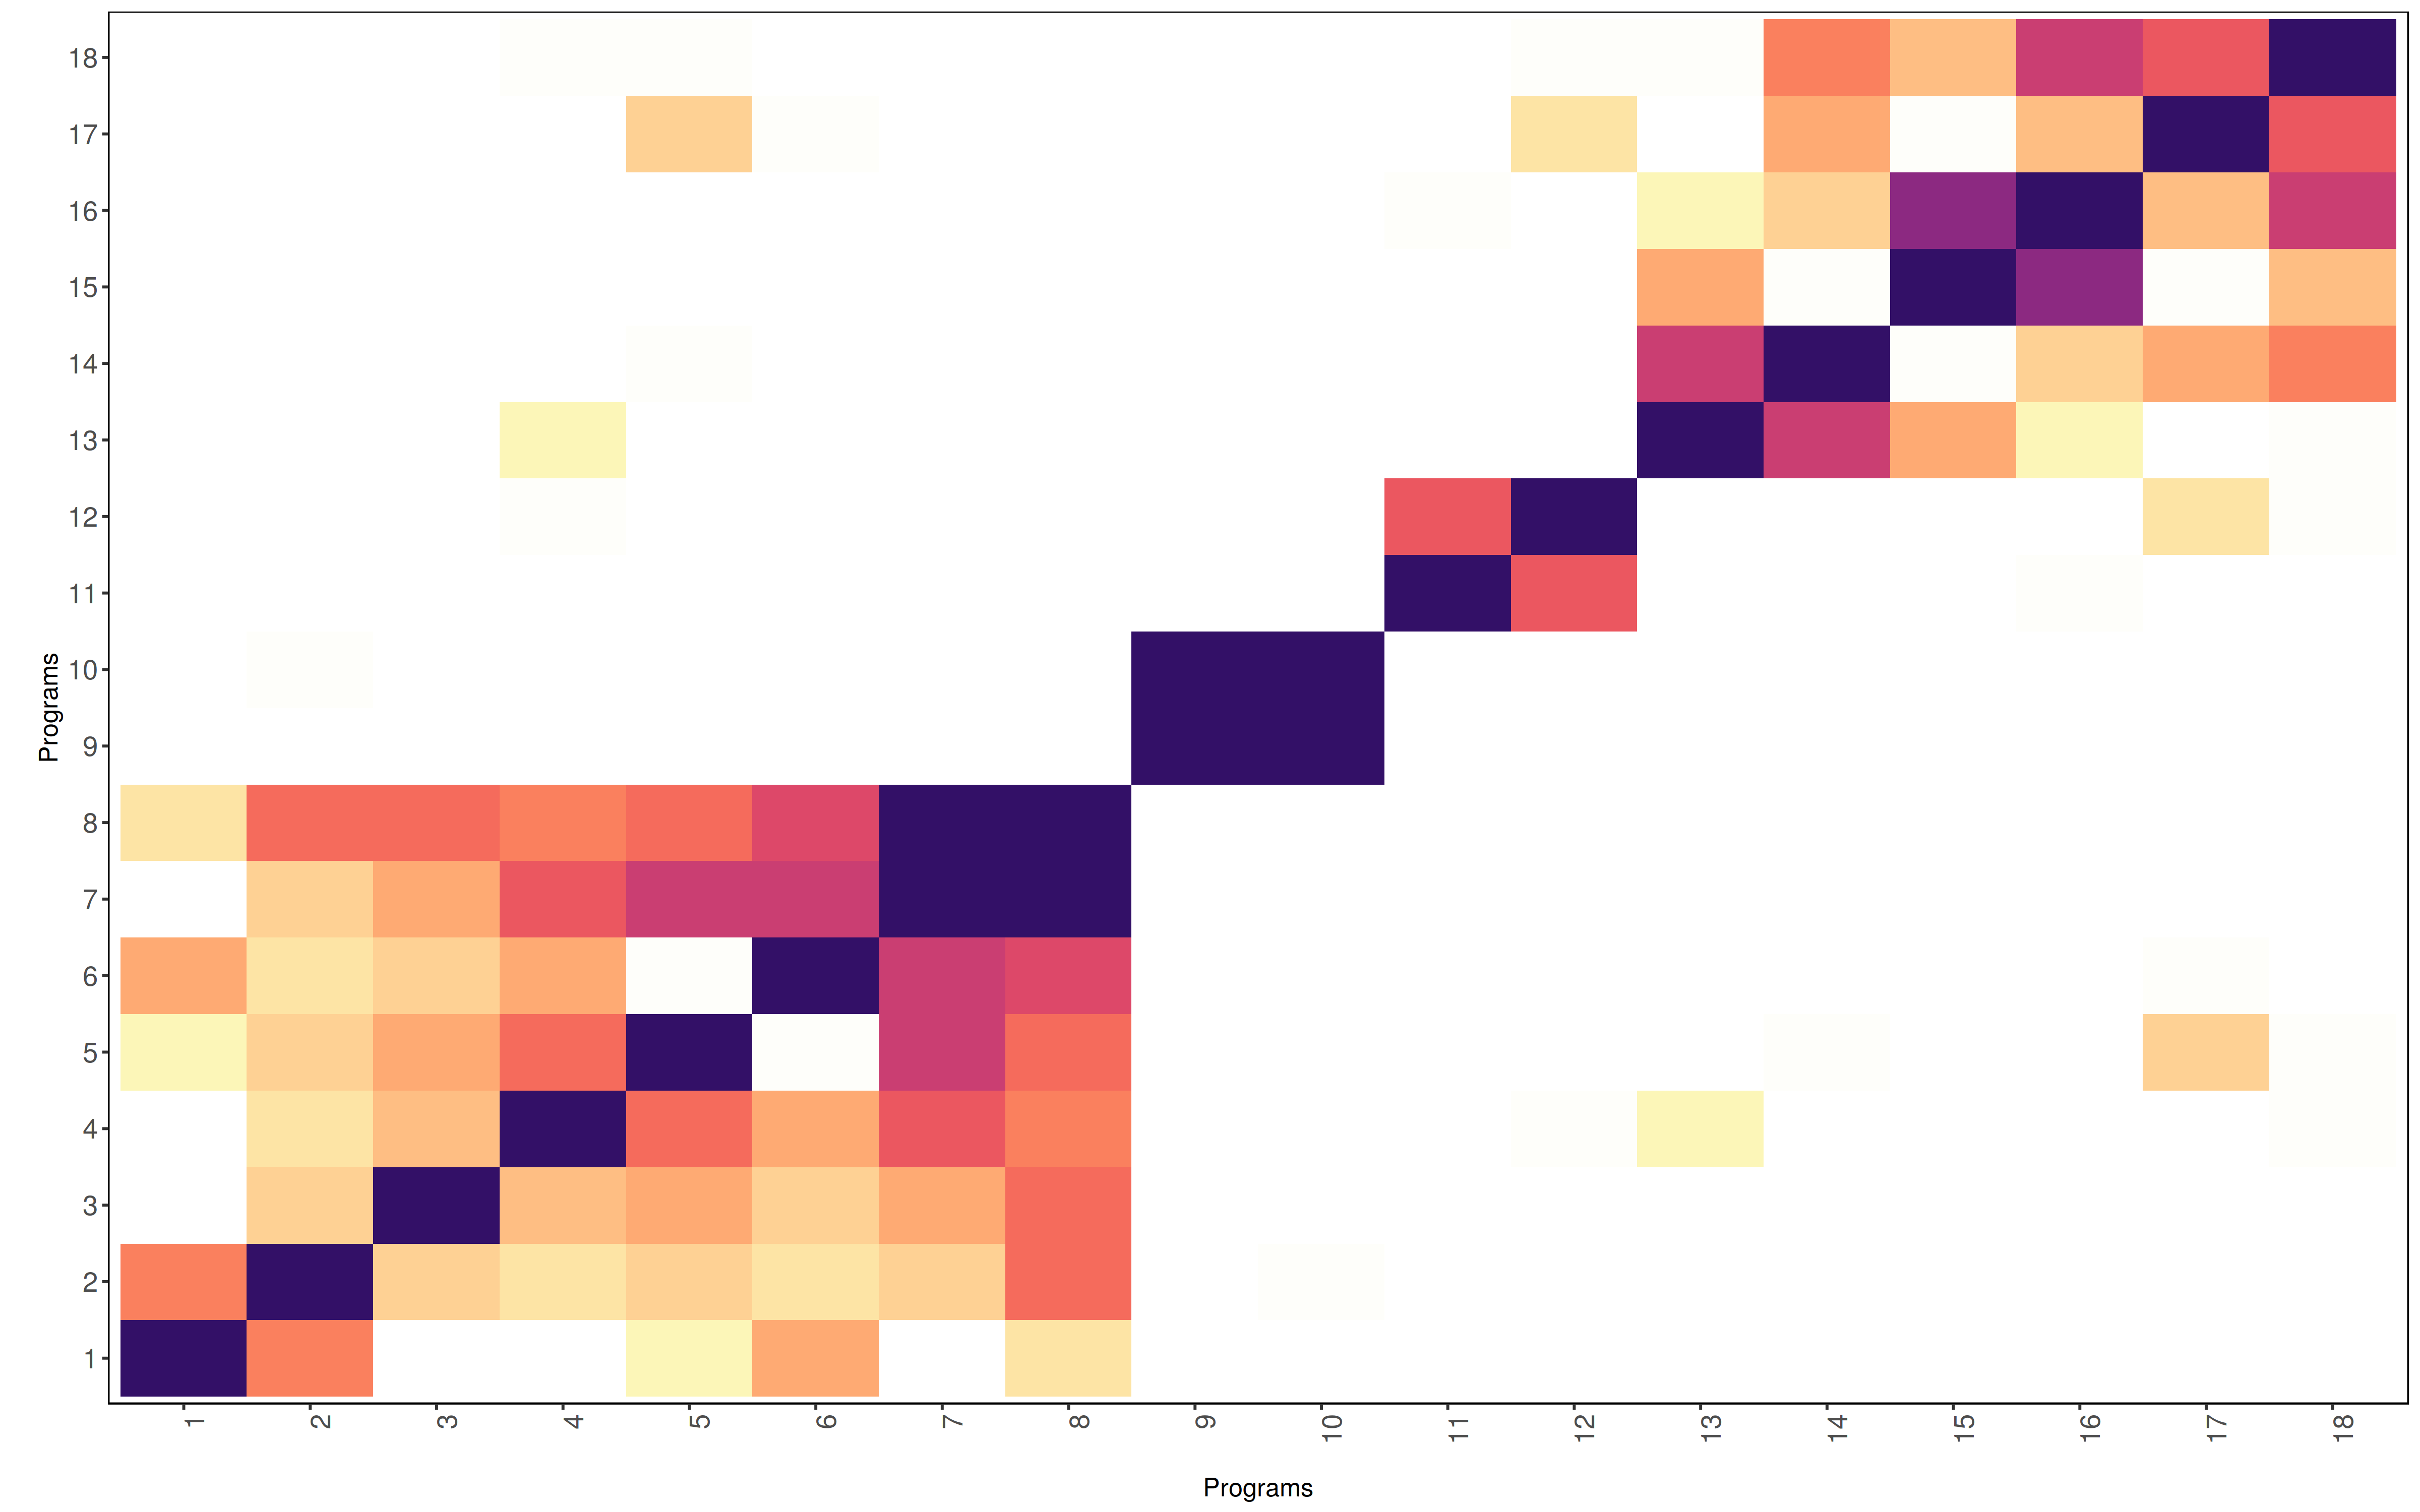

In [90]:
nmf_intersect_melt_tumor <- reshape2::melt(nmf_intersect_tumor) 
# Custom color palette
library(RColorBrewer)
library(viridis)
custom_magma <- c(colorRampPalette(c("white", rev(magma(323, begin = 0.15))[1]))(10), rev(magma(323, begin = 0.18)))
p5.1 <- ggplot(data = nmf_intersect_melt_tumor, aes(x=Var1, y=Var2, fill=100*value/(100-value))) + 
  geom_tile() + 
  #geom_text(data = nmf_intersect_melt_tumor[nmf_intersect_melt_tumor$value >= 2,], aes(label = round(100*value/(100-value))), color = 'lightgrey', fontface = 'bold') +
  scale_color_gradient2(limits=c(2,25), low=custom_magma[1:111],  mid =custom_magma[112:222], high = custom_magma[223:333], midpoint = 13.5, 
                        oob=scales::squish, name="Similarity\n(Jaccard index)") +                                
  scale_fill_gradient2( limits=c(2,25), low=custom_magma[1:111],  mid =custom_magma[112:222], high = custom_magma[223:333], midpoint = 13.5, 
                       oob=scales::squish, name="Similarity\n(Jaccard index)")  +
  
  scale_x_discrete(name="\nPrograms", label = c(1:18)) + 
  scale_y_discrete(name="\nPrograms",  label = c(1:18))  +
  geom_vline(xintercept=c(424,504), linetype="longdash", size=0.6)+
  guides(fill = guide_colourbar(barheight = 4, barwidth = 1)) +
  theme(#plot.background = element_rect(fill = 'lightgrey'), axis.ticks = element_blank(), 
        panel.border = element_rect(fill=F), 
        panel.background = element_blank(),  
        axis.line = element_blank(), 
        axis.text = element_text(size = 13), 
        axis.title = element_text(size = 12), 
        axis.text.x = element_text(angle = 90, hjust = 1 ,vjust = 1),
        legend.position = 'top',
        legend.title = element_text(size=11), 
        legend.text = element_text(size = 10), legend.text.align = 0.5, legend.justification = "bottom") 
p5.1
ggsave(p5.1, filename = "../figures/Figure4/Figure4K_NMF_programs.pdf", width = 6, height = 6)


# Define metaprograms 
Genes observed in at least 25% of programs composing the respective metacluster) 

In [41]:
colnames(nmf_intersect_tumor)

[1] "D20170327_7.3" "D20171220_9.7" "D20170327_9.1" "D20170327_9.7"
 [5] "D20180110_4.1" "D20180110_4.3" "D20170322_6.2" "D20171220_6.3"
 [9] "D20180110_5.5" "D20171220_7.1" "D20170327_5.3" "D20171220_7.2"
[13] "D20170327_7.7" "D20180110_9.2" "D20170327_4.2" "D20180110_7.7"
[17] "D20171220_5.4" "D20170322_6.6"

In [42]:
nmf_meta1_tumor <- sort(table(nmf_programs_sig_tumor[,colnames(nmf_intersect_tumor)[1:8]])/length(1:8), decreasing=T)
nmf_meta1_tumor_programs <- colnames(nmf_intersect_tumor)[1:8] 

nmf_meta2_tumor <- sort(table(nmf_programs_sig_tumor[,colnames(nmf_intersect_tumor)[9:10]])/length(9:10), decreasing=T)
nmf_meta2_tumor_programs <- colnames(nmf_intersect_tumor)[9:10]

nmf_meta3_tumor <- sort(table(nmf_programs_sig_tumor[,colnames(nmf_intersect_tumor)[11:12]])/length(11:12), decreasing=T)
nmf_meta3_tumor_programs <- colnames(nmf_intersect_tumor)[11:12] 

nmf_meta4_tumor <- sort(table(nmf_programs_sig_tumor[,colnames(nmf_intersect_tumor)[13:18]])/length(13:18), decreasing=T)
nmf_meta4_tumor_programs <- colnames(nmf_intersect_tumor)[13:18] 

In [43]:
nmf_programs_genes <- list(Hepatocytes = nmf_meta1_tumor,  CellCycle  = nmf_meta2_tumor, ImmuneResist = nmf_meta3_tumor, Stem = nmf_meta4_tumor )

In [44]:
nmf_programs <- list(nmf_program_similarity = nmf_intersect_tumor , nmf_program_hclust = nmf_intersect_hc_tumor)

In [45]:
genes <- names(nmf_programs_genes$Stem)

In [46]:
genes

[1] "DST"                      "FOS"                     
  [3] "THBS1"                    "ATF3"                    
  [5] "CLK1"                     "DUSP1"                   
  [7] "EGR1"                     "GDF15"                   
  [9] "HOOK3"                    "IER2"                    
 [11] "JUNB"                     "KRT7"                    
 [13] "MALAT1_ENSG00000279576"   "NCOA7"                   
 [15] "PPP1R15A"                 "SORBS2"                  
 [17] "SPTBN1"                   "TM4SF1"                  
 [19] "ABCC3"                    "BICC1"                   
 [21] "C8orf4"                   "CCNL1"                   
 [23] "CD24"                     "CDH6"                    
 [25] "CLDN4"                    "CLK4"                    
 [27] "CXCL2"                    "CYR61"                   
 [29] "DSP"                      "DTNA"                    
 [31] "ENAH"                     "FAM171A1"                
 [33] "FAM46A"                   "FLNA"                    
 [35] "FLNB"                     "FOSB"                    
 [37] "GOLGA8B"                  "GPAM"                    
 [39] "IGFBP1"                   "JUN"                     
 [41] "KLF6"                     "MDM4"                    
 [43] "MLXIPL"                   "MUC3A"                   
 [45] "NKTR"                     "OCLN"                    
 [47] "PDZK1IP1"                 "PPARGC1A"                
 [49] "RBM39"                    "SLC12A2"                 
 [51] "SLC17A4"                  "SLC38A2"                 
 [53] "SPON2"                    "TIMP1"                   
 [55] "TNFRSF12A"                "TSPAN15"                 
 [57] "ZBTB20"                   "AASS"                    
 [59] "ABCA6"                    "ABCB1"                   
 [61] "ABCB11"                   "ABCB4"                   
 [63] "ABCC2"                    "ABCG5"                   
 [65] "ABLIM1"                   "AHNAK"                   
 [67] "APCS"                     "ARID4A"                  
 [69] "ARID5B"                   "ARRDC2"                  
 [71] "ARRDC3"                   "ATP1A1"                  
 [73] "BCL6"                     "BGN"                     
 [75] "BRD8"                     "BSDC1"                   
 [77] "BTAF1"                    "BTG2"                    
 [79] "C10orf10"                 "C1orf186"                
 [81] "CACUL1"                   "CADM1"                   
 [83] "CAP2"                     "CAV1"                    
 [85] "CAV2"                     "CD109"                   
 [87] "CD58"                     "CDH1"                    
 [89] "CDR2"                     "CGN"                     
 [91] "CHD9"                     "CLDN1"                   
 [93] "CLDN3"                    "CLDN7"                   
 [95] "CNTNAP2"                  "CPE"                     
 [97] "CPNE8"                    "CRP"                     
 [99] "CTGF"                     "CTSH"                    
[101] "CXADR"                    "CXCL16"                  
[103] "CXCL8"                    "CYP3A5"                  
[105] "DBNDD1"                   "DOCK5"                   
[107] "DPP4"                     "ELF3"                    
[109] "EPCAM"                    "ERBB3"                   
[111] "FAM118A"                  "FGD4"                    
[113] "FGFR2"                    "FLRT3"                   
[115] "FSTL3"                    "GPLD1"                   
[117] "GPR56"                    "HAL"                     
[119] "HNRNPH1"                  "HOMER2"                  
[121] "HSD11B1"                  "HSPA1B"                  
[123] "HSPA6"                    "HTRA1"                   
[125] "ID2"                      "IER3"                    
[127] "IFT57"                    "IGFBP3"                  
[129] "INSR"                     "IQGAP2"                  
[131] "ITIH5"                    "JMJD1C"                  
[133] "KIAA1217"                 "KLF10"  

In [ ]:
saveRDS(nmf_programs, file = "./output/NMF/NMF_programs.rds")
saveRDS(nmf_programs_genes, file = "./output/NMF/NMF_programs_genes.rds")

# Visualizating meta programs

In [47]:
suppressPackageStartupMessages(library(Seurat))
sr <- as.Seurat(sce)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca_ to Xpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xpca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umap_ to Xumap_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xumap_”


In [48]:
nmf_metaprogram_genes <- lapply(nmf_programs_genes, function(x) data.frame(genes = names(x[x > 0.3])))

In [23]:
openxlsx::write.xlsx(nmf_metaprogram_genes, file = "./nmf_program_genes.xlsx")

ERROR: Error in saveWorkbook(wb, file = file, overwrite = overwrite): File already exists!


In [49]:
#colData(sce) <- cbind(colData(sce), sr@meta.data[, c("Cluster1", "Cluster2", "Cluster3", "Cluster4")])
plotDF <- makePerCellDF(sce)

In [102]:
library(msigdbr)
msigdbr_df = msigdbr(species = "human", category = c("C5")) %>% dplyr::filter(gs_subcat %in% c("GO:BP", "GO:CC"))
msigdbr_df = rbind(msigdbr_df ,msigdbr(species = "human", category = c("C2")))

In [103]:
library(clusterProfiler)
genes <- nmf_metaprogram_genes$Stem$genes

msigdbr_t2g = msigdbr_df %>% dplyr::distinct(gs_name,gene_symbol ) %>% as.data.frame()
enrichRes <- enricher(gene = genes, TERM2GENE = msigdbr_t2g)@result
enrichRes <- enrichRes %>% 
    filter(qvalue < 0.01) %>% 
    dplyr::mutate(hitGenes = as.integer(sapply(strsplit(GeneRatio , split = "\\/"), `[[`, 1))) 
    
    

In [77]:
#enrichRes %>% head(30) %>% as_tibble() %>% select(-ID)

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


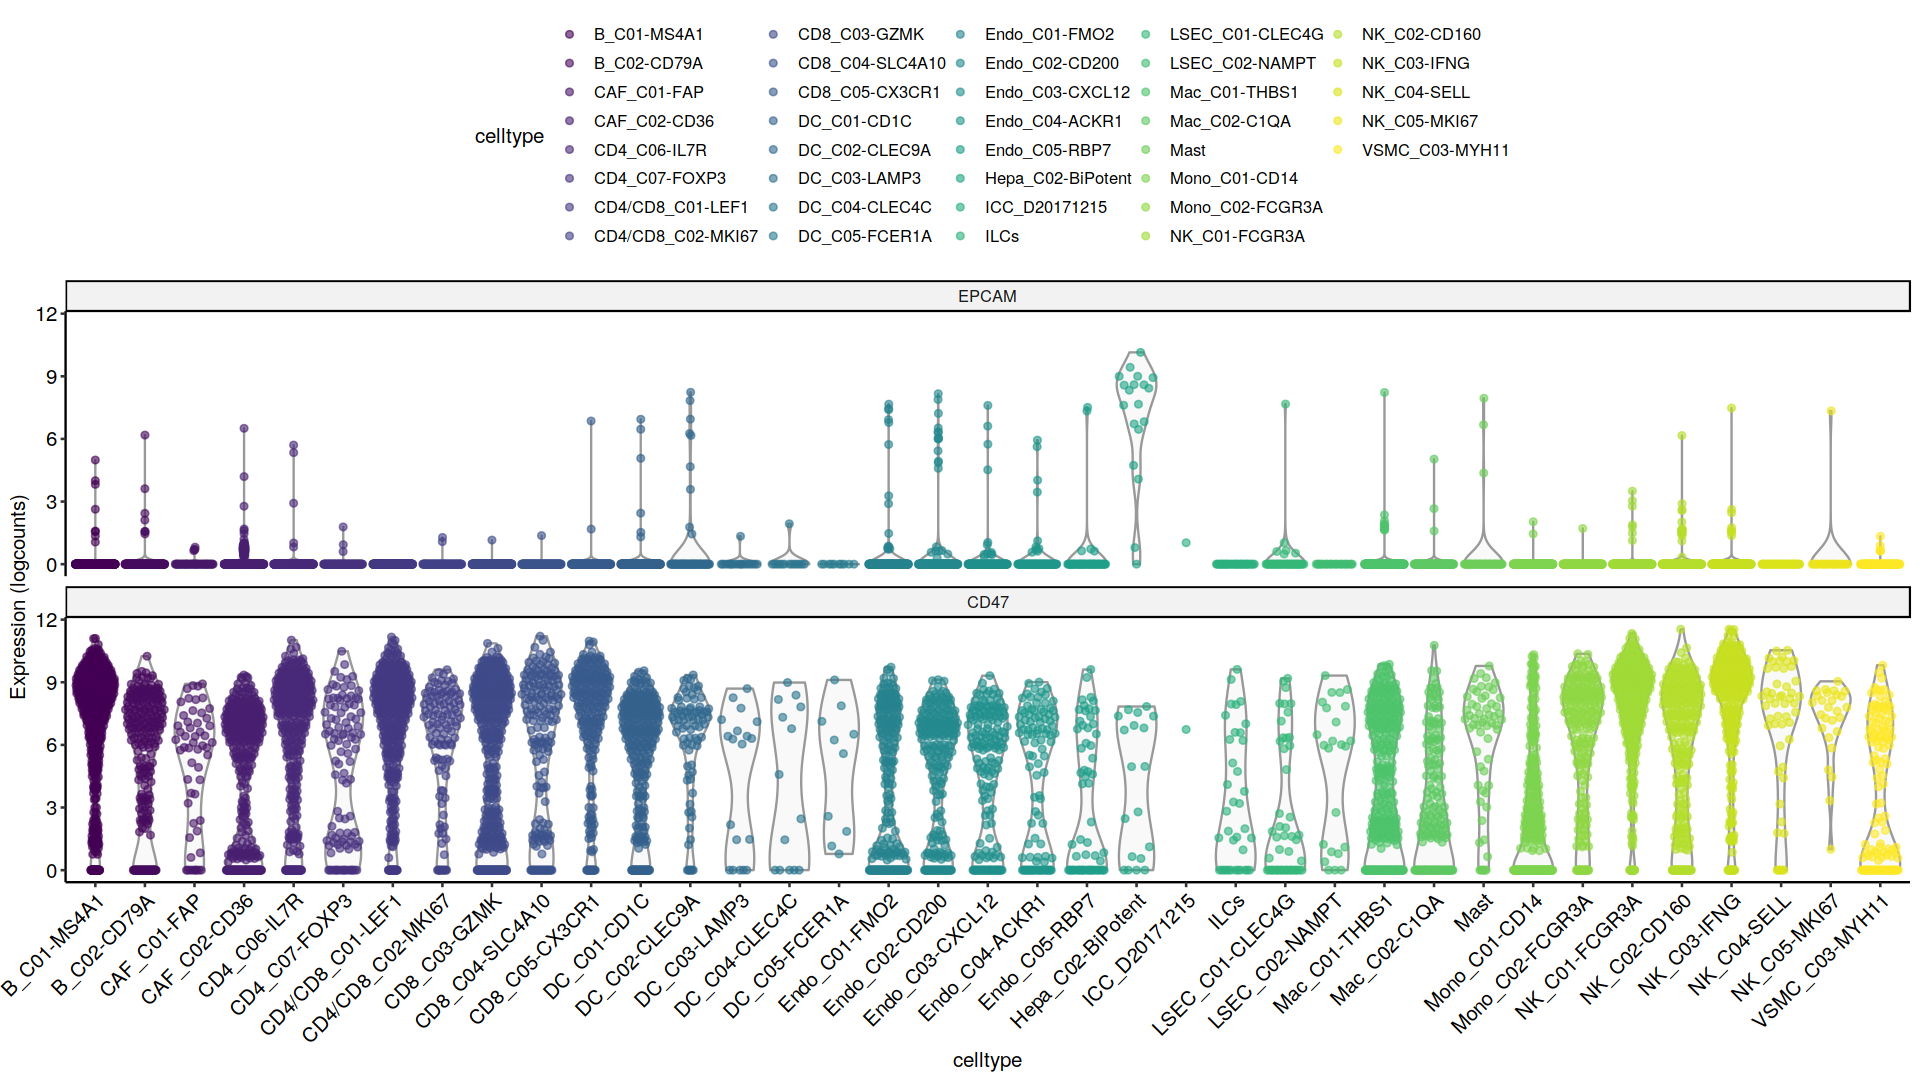

In [104]:
options(repr.plot.width = 16, repr.plot.height = 9)
plotExpression(sce, x = 'celltype', features = c("EPCAM", "CD47"), colour_by = 'celltype', ncol = 1) + ggpubr::theme_pubr(x.text.angle = 45 )

In [105]:
enrichRes %>% filter(grepl("STEM", ID)) 

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,hitGenes
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>
BOQUEST_STEM_CELL_CULTURED_VS_FRESH_UP,BOQUEST_STEM_CELL_CULTURED_VS_FRESH_UP,BOQUEST_STEM_CELL_CULTURED_VS_FRESH_UP,16/53,427/20881,5.257176e-15,1.150445e-12,7.037238e-13,THBS1/ATF3/CLK1/DUSP1/EGR1/GDF15/JUNB/KRT7/PPP1R15A/SPTBN1/CCNL1/CXCL2/DSP/JUN/KLF6/ZBTB20,16,16
OSWALD_HEMATOPOIETIC_STEM_CELL_IN_COLLAGEN_GEL_UP,OSWALD_HEMATOPOIETIC_STEM_CELL_IN_COLLAGEN_GEL_UP,OSWALD_HEMATOPOIETIC_STEM_CELL_IN_COLLAGEN_GEL_UP,12/53,222/20881,2.813330e-13,3.542593e-11,2.166993e-11,FOS/ATF3/DUSP1/EGR1/IER2/JUNB/PPP1R15A/CXCL2/FOSB/JUN/KLF6/SLC12A2,12,12
LEE_NEURAL_CREST_STEM_CELL_DN,LEE_NEURAL_CREST_STEM_CELL_DN,LEE_NEURAL_CREST_STEM_CELL_DN,5/53,122/20881,1.437712e-05,2.302092e-04,1.408182e-04,FOS/GDF15/SORBS2/DSP/DTNA,5,5
JINESH_BLEBBISHIELD_TRANSFORMED_STEM_CELL_SPHERES_DN,JINESH_BLEBBISHIELD_TRANSFORMED_STEM_CELL_SPHERES_DN,JINESH_BLEBBISHIELD_TRANSFORMED_STEM_CELL_SPHERES_DN,7/53,378/20881,4.536387e-05,6.140491e-04,3.756118e-04,FOS/ATF3/DUSP1/EGR1/JUNB/PPP1R15A/FOSB,7,7
IVANOVA_HEMATOPOIESIS_STEM_CELL_LONG_TERM,IVANOVA_HEMATOPOIESIS_STEM_CELL_LONG_TERM,IVANOVA_HEMATOPOIESIS_STEM_CELL_LONG_TERM,5/53,214/20881,2.075489e-04,2.180094e-03,1.333557e-03,KRT7/BICC1/OCLN/SLC12A2/ZBTB20,5,5


In [50]:
module_df <- do.call(rbind, lapply(1:4, function(idx) data.frame(Module = names(nmf_metaprogram_genes)[idx], Gene = nmf_metaprogram_genes[[idx]])))

In [25]:
table(sce$celltype)


      B_C01-MS4A1       B_C02-CD79A       CAF_C01-FAP      CAF_C02-CD36 
              657               267                55               414 
     CD4_C06-IL7R     CD4_C07-FOXP3  CD4/CD8_C01-LEF1 CD4/CD8_C02-MKI67 
              388               106               412               115 
     CD8_C03-GZMK   CD8_C04-SLC4A10    CD8_C05-CX3CR1       DC_C01-CD1C 
              512               186               244               331 
    DC_C02-CLEC9A      DC_C03-LAMP3     DC_C04-CLEC4C     DC_C05-FCER1A 
               83                19                14                10 
    Endo_C01-FMO2    Endo_C02-CD200   Endo_C03-CXCL12    Endo_C04-ACKR1 
              283               257               181               105 
    Endo_C05-RBP7 Hepa_C02-BiPotent     ICC_D20171215              ILCs 
               63                19                 1                37 
  LSEC_C01-CLEC4G    LSEC_C02-NAMPT     Mac_C01-THBS1      Mac_C02-C1QA 
               51                24               

In [51]:
sce[module_df$genes,]

class: SingleCellExperiment 
dim: 246 670 
metadata(4): pca neighbors umap leiden
assays(3): logcounts counts cpm
rownames(246): PLG GPC3 ... TSPAN15 ZBTB20
rowData names(10): Geneid Chr ... highly_variable varm
colnames(670): TP5-100-0322 TP5-108-0322 ... TP5-9-20180110
  TP5-95-20180110
colData names(31): cell.id cell.type ... leiden_sub leiden_anno
reducedDimNames(4): PCA UMAP X_pca X_umap
mainExpName: NULL
altExpNames(0):

In [52]:
sub <- sce[, sce$donor %in% c("D20170322", "D20170327", "D20171220", "D20180110")]

In [53]:
sub

class: SingleCellExperiment 
dim: 60682 619 
metadata(4): pca neighbors umap leiden
assays(3): logcounts counts cpm
rownames(60682): DDX11L1 WASH7P_ENSG00000227232 ... HPV-mRTRX7 HPV-mSD2
rowData names(10): Geneid Chr ... highly_variable varm
colnames(619): TP5-100-0322 TP5-108-0322 ... TP5-9-20180110
  TP5-95-20180110
colData names(31): cell.id cell.type ... leiden_sub leiden_anno
reducedDimNames(4): PCA UMAP X_pca X_umap
mainExpName: NULL
altExpNames(0):

In [ ]:
logcounts(sub[ module_df$genes, ])

In [54]:
mt <- as.matrix(logcounts(sub[ module_df$genes, ]))
#mt <- avg[ module_df$genes, ]
mt <- mt - rowMeans(mt)
ha <- HeatmapAnnotation( Tissue = colData(sub)$tissue)
rowAnnotation()

In [68]:
genes <- c(c("CTNNB1", "MKI67", "CCNA2", "BIRC5"), c("HMGCS2", "HP", "AHSG", "CYP2C0", "ALB", "TTR"), 
           c("EPCAM", "CD24", "CDH6", "ATF3", "KRT7", "THBS1", "CLDN4"), c("CD74", "HLA-DMA", "HLA-DPA1", "HLA-DQB1", "HLA-DRA"))
rha <- rowAnnotation(Gene = anno_mark(at = which(rownames(mt) %in% genes), labels = rownames(mt)[which(rownames(mt) %in% genes)]))

In [76]:
rha

A HeatmapAnnotation object with 1 annotation
  name: heatmap_annotation_9 
  position: row 
  items: unknown 
  width: 27.2334666666667mm 
  height: 1npc 
  this object is subsetable

 name annotation_type color_mapping              width
 Gene     anno_mark()               27.2334666666667mm

In [72]:
rownames(mt)[which(rownames(mt) %in% genes)]

[1] "HP"       "AHSG"     "TTR"      "BIRC5"    "CCNA2"    "CD74"    
 [7] "HLA-DMA"  "HLA-DPA1" "HLA-DQB1" "HLA-DRA"  "THBS1"    "ATF3"    
[13] "KRT7"     "CD24"     "CDH6"     "CLDN4"

In [73]:
dim(mt)

[1] 246 619

In [89]:
for(d in unique(sub$donor)) {
    pdf(file.path("./output/", paste0(d, ".pdf")), height = 8, width = 5)
    col_fun <- circlize::colorRamp2(c(-5, 0, 5), c("darkblue", "white", "darkred"))
    ssub <- sub[, sub$donor == d]
    ht <- Heatmap(mt[, colnames(ssub)], name = 'Relative Expr.', col = col_fun, cluster_rows = T,  right_annotation = rha, row_split = module_df$Module,
        column_split =  ssub$donor, use_raster = T, show_column_dend = F,
       #left_annotation =  rowAnnotation( Module = module_df$Module),
        show_row_names = F,  show_row_dend = F, 
        clustering_method_columns = "ward.D2", clustering_method_rows = 'ward.D2', show_column_names = F, border = T) 
draw(ht)
dev.off()
}

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



In [84]:
options(repr.plot.width = 16, repr.plot.height = 10, repr.plot.res = 300)
pdf("test.pdf", width = 12, height = 8)


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

In [82]:
dev.off()

pdf 
  3

In [187]:
sub <- sce[, sce$donor %in% c("D20170327", "D20171220", "D20180110")]

In [ ]:
mt <- as.matrix(logcounts(sub[ module_df$Gene, ]))
mt <- mt - rowMeans(mt)
ha <- HeatmapAnnotation( Tissue = colData(sub)$tissue)


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



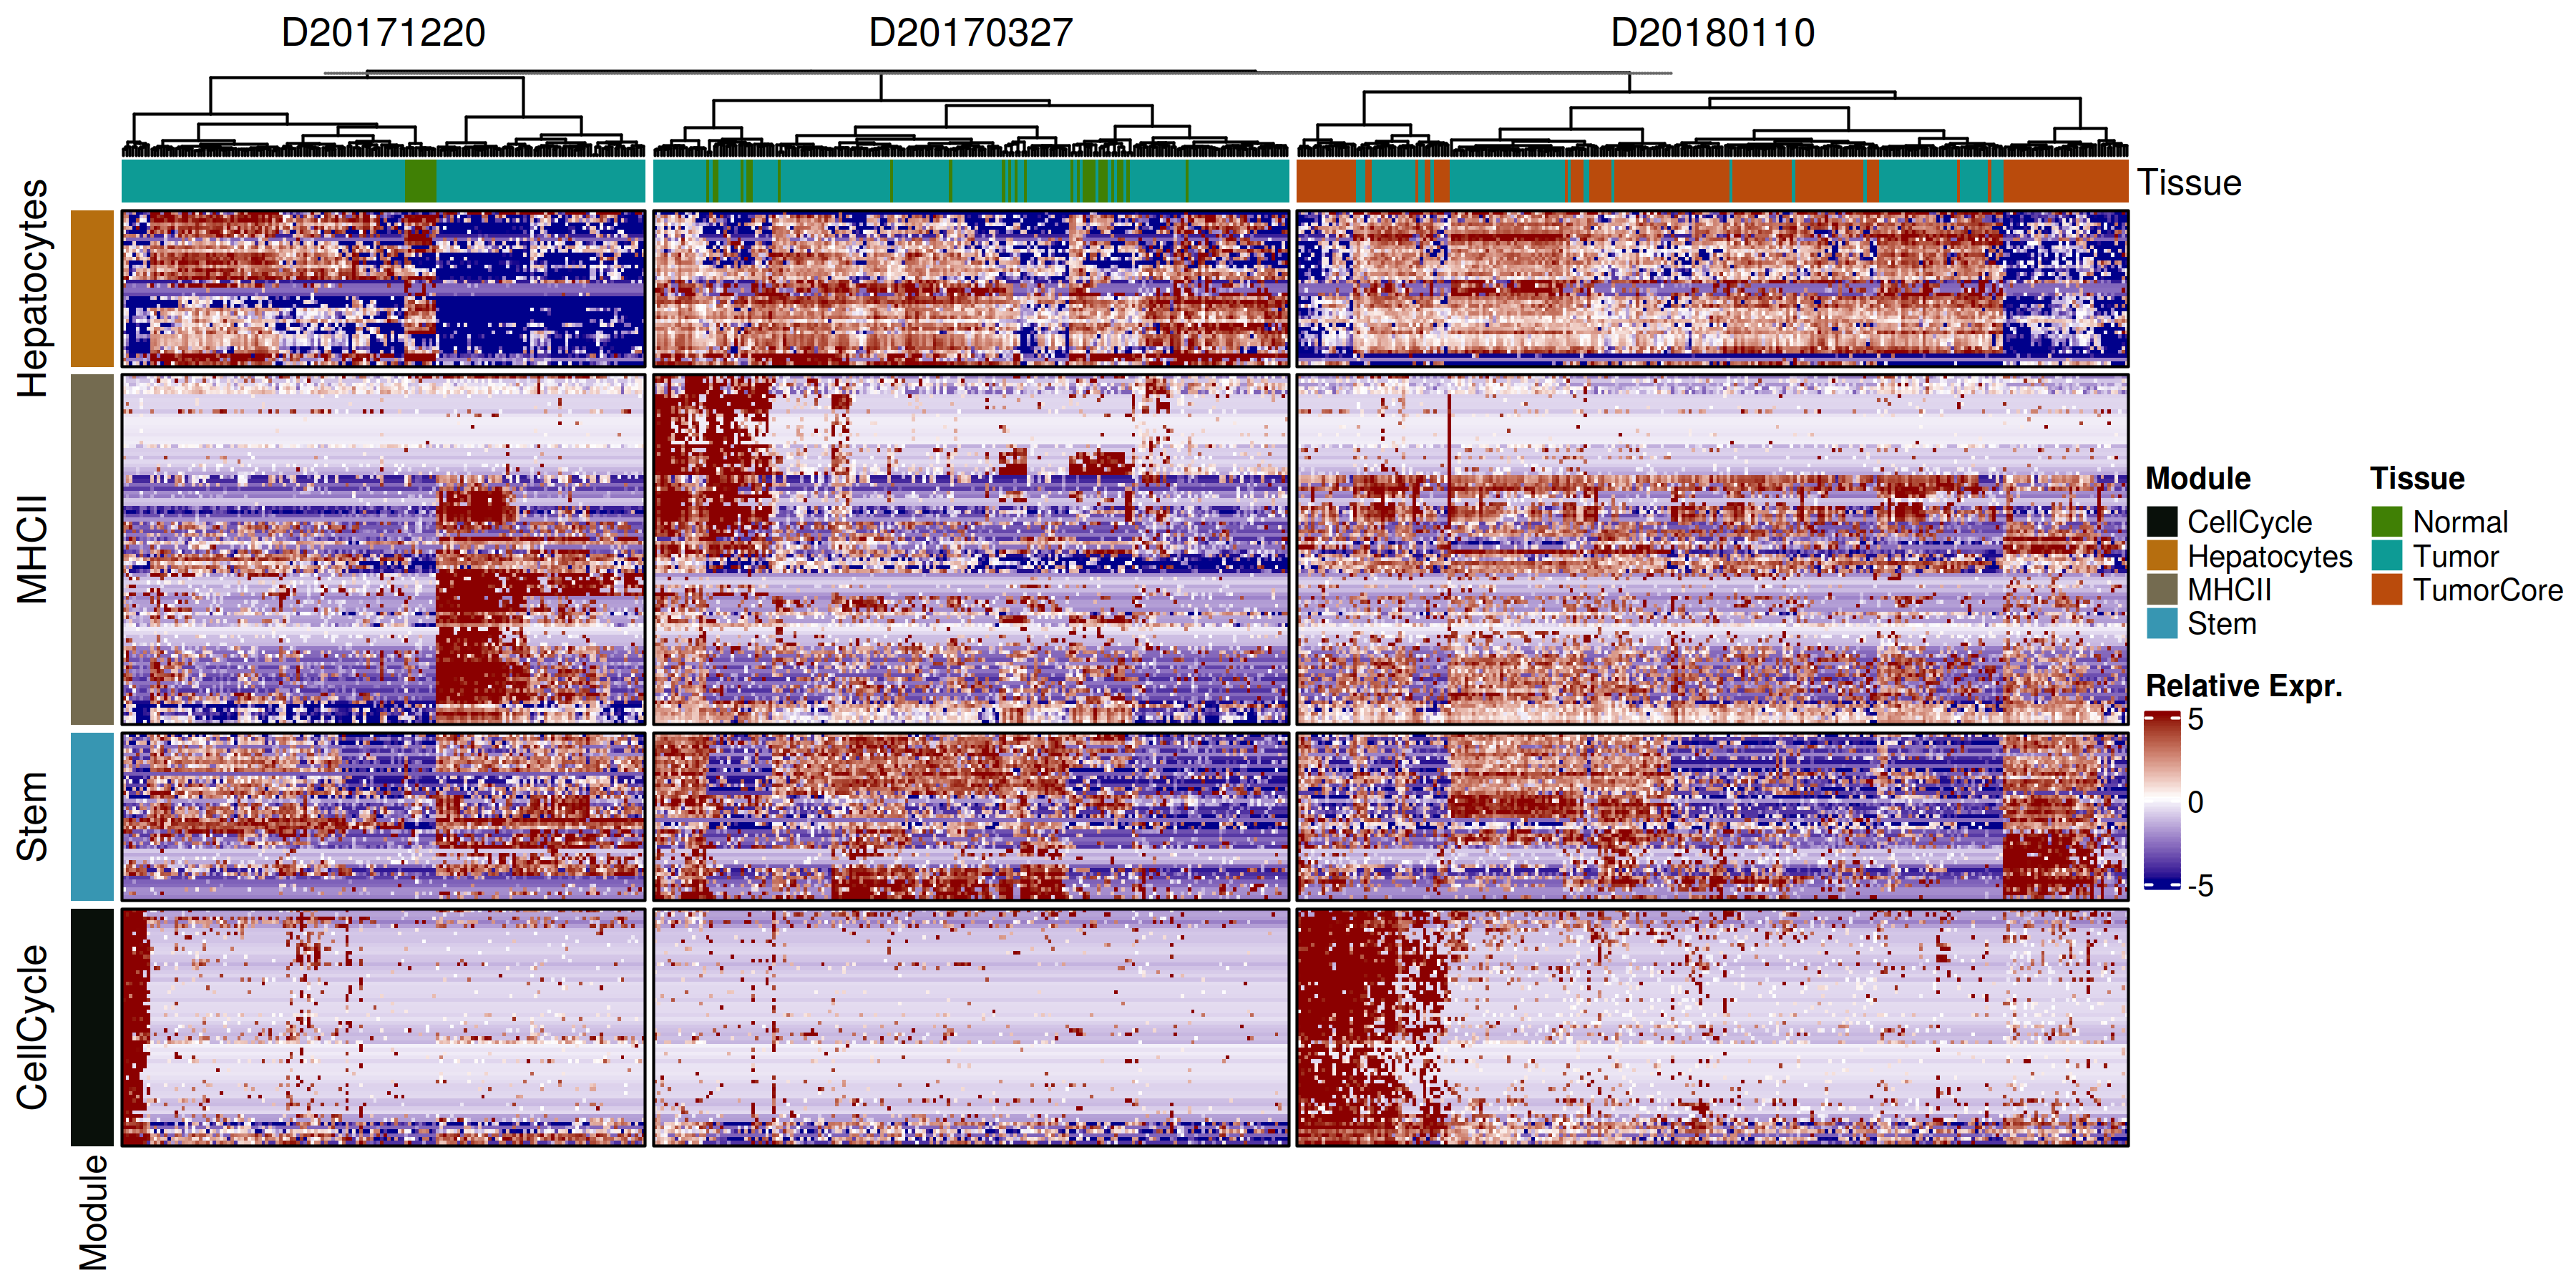

In [248]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 300)
col_fun <- circlize::colorRamp2(c(-5, 0, 5), c("darkblue", "white", "darkred"))
Heatmap(mt, name = 'Relative Expr.', col = col_fun, cluster_rows = T,  row_split = module_df$Module,use_raster = T,
        top_annotation = ha, left_annotation =  rowAnnotation( Module = module_df$Module),
        show_row_names = F, column_split = sub$donor, show_row_dend = F, 
        clustering_method_columns = "ward.D2", clustering_method_rows = 'ward.D2', show_column_names = F, border = T) 